<a href="https://colab.research.google.com/github/bominwang/MFMM/blob/main/Simplicity_Demo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEMO function:
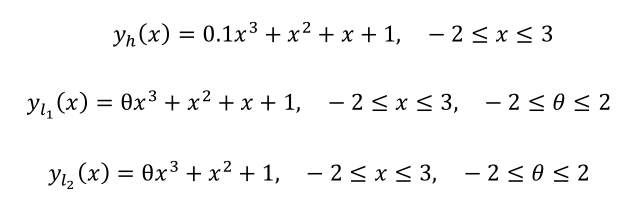

In [186]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import tqdm
!pip install pyDOE
import pyDOE 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [187]:
def func(flag, x):
  if flag == 1:
    y = 0.1 * np.power(x, 3) + np.power(x, 2) + x + 1
  elif flag == 2:
    y = 0.3 * np.power(x, 3) + np.power(x, 2) + x + 1
  else:
    y = 0.22 * np.power(x, 3) + np.power(x, 2) + 1
  return y

In [188]:
x = np.linspace(-2, 3, 100)
y_h, y_l1, y_l2 = func(1, x), func(2, x), func(3, x)

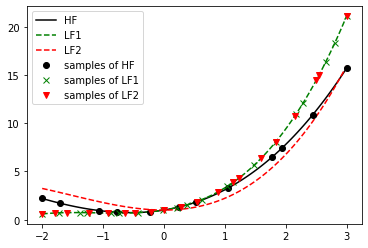

In [189]:
def samples_map(x, low, up):
  return low + ((up - low) / (np.max(x) - np.min(x))) * (x - np.min(x))

x_highlevel, x_lowlevel1, x_lowlevel2 = samples_map(pyDOE.lhs(1, samples = 12), -2, 3), samples_map(pyDOE.lhs(1, samples = 20), -2, 3), samples_map(pyDOE.lhs(1, samples = 20), -2, 3)

y_highlevel, y_lowlevel1, y_lowlevel2 = func(1, x_highlevel), func(2, x_lowlevel1), func(2, x_lowlevel2)


plt.figure(2)
plt.plot(x, y_h, 'k-')
plt.plot(x, y_l1, 'g--')
plt.plot(x, y_l2, 'r--')
plt.plot(x_highlevel, y_highlevel, 'ko')
plt.plot(x_lowlevel1, y_lowlevel1, 'gx')
plt.plot(x_lowlevel2, y_lowlevel2, 'rv')
plt.legend(['HF', 'LF1', 'LF2','samples of HF', 'samples of LF1', 'samples of LF2'])
plt.show()

In [190]:
class LFNN(nn.Module):
  def __init__(self):
    super(LFNN, self).__init__()

    self.input_layer = nn.Sequential(
        nn.Linear(1, 6),
        nn.BatchNorm1d(6),
        nn.ReLU()
    )
    self.hidden_layer = nn.Sequential(
        nn.Linear(6, 14),
        nn.BatchNorm1d(14),
        nn.ReLU()
    )
    self.output_layer = nn.Sequential(
        nn.Linear(14, 1)
    )
  
  def forward(self, x):
    
    x = self.input_layer(x)
    x = self.hidden_layer(x)
    y = self.output_layer(x)
    
    return y

In [191]:
LF1_model = LFNN()
LF2_model = LFNN()

In [192]:
x_lowlevel1, x_lowlevel2 = torch.from_numpy(x_lowlevel1), torch.from_numpy(x_lowlevel2)

y_lowlevel1, y_lowlevel2 = torch.from_numpy(y_lowlevel1), torch.from_numpy(y_lowlevel2)

train_set_lowlevel1 = TensorDataset(x_lowlevel1[0 : 15, 0], y_lowlevel1[0 : 15, 0])
train_set_lowlevel1 = DataLoader(train_set_lowlevel1, batch_size = 20, shuffle = True)


train_set_lowlevel2 = TensorDataset(x_lowlevel2[0 : 15, 0], y_lowlevel2[0 : 15, 0])
train_set_lowlevel2 = DataLoader(train_set_lowlevel2, batch_size = 20, shuffle = True)



In [193]:
loss_train = [];
loss_test = [];
loss_func = nn.SmoothL1Loss()
optimizer = torch.optim.SGD(LF1_model.parameters(),lr = 0.01)
for epoch in range(500):
    for i, data in enumerate(train_set_lowlevel1):
        inputs, labs = data
        inputs, labs = Variable(inputs), Variable(labs)
        LF1_model.train()
        inputs = inputs.reshape(-1,1).to(torch.float32)
        labs = labs.reshape(-1,1).to(torch.float32)
        preds = LF1_model(inputs)
        l = loss_func(preds, labs)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        loss_train.append(l.item())
        
        LF1_model.eval()
        pred = LF1_model(x_lowlevel1[15 : 21, 0].reshape(-1,1).to(torch.float32))
        l = loss_func(pred, y_lowlevel1[15 : 21, 0].reshape(-1,1).to(torch.float32))
        loss_test.append(l.item())

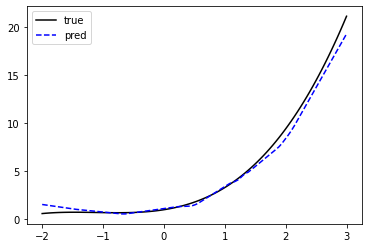

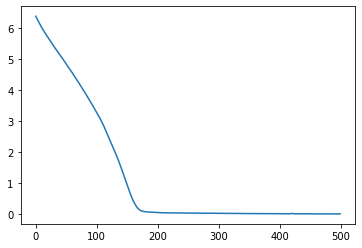

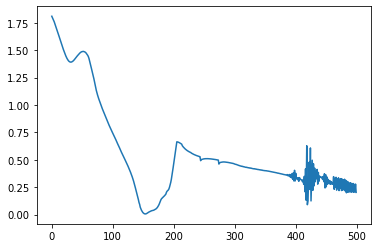

In [194]:
xx = torch.from_numpy(x).to(torch.float32).reshape(-1,1)
pred = LF1_model(xx)
plt.figure(3)
plt.plot(x, y_l1, 'k-')
plt.plot(xx.detach().numpy(), pred.detach().numpy(), 'b--')
plt.legend(['true','pred'])
plt.show()
plt.figure(4)
plt.plot(loss_train)
plt.figure(5)
plt.plot(loss_test)

In [195]:
loss_train2 = [];
loss_test2 = [];
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(LF2_model.parameters(),lr = 0.01)
for epoch in range(200):
    for i, data in enumerate(train_set_lowlevel2):
        inputs, labs = data
        inputs, labs = Variable(inputs), Variable(labs)
        LF2_model.train()
        inputs = inputs.reshape(-1,1).to(torch.float32)
        labs = labs.reshape(-1,1).to(torch.float32)
        preds = LF2_model(inputs)
        l = loss_func(preds, labs)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        loss_train2.append(l.item())
        
        LF2_model.eval()
        pred = LF2_model(x_lowlevel2[15 : 21, 0].reshape(-1,1).to(torch.float32))
        l = loss_func(pred, y_lowlevel2[15 : 21, 0].reshape(-1,1).to(torch.float32))
        loss_test2.append(l.item())

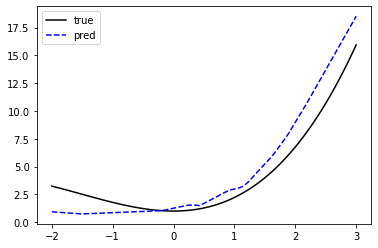

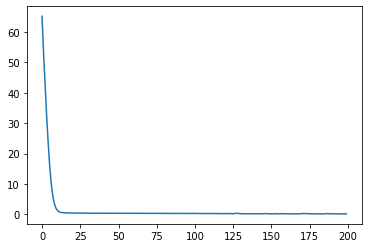

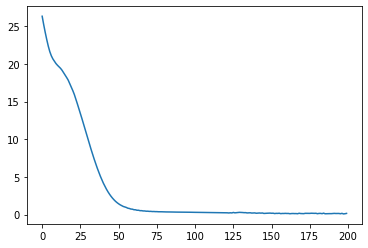

In [196]:
pred = LF2_model(xx)
plt.figure(4)
plt.plot(x, y_l2, 'k-')
plt.plot(xx.detach().numpy(), pred.detach().numpy(), 'b--')
plt.legend(['true','pred'])
plt.show()
plt.figure(4)
plt.plot(loss_train2)
plt.figure(5)
plt.plot(loss_test2)

In [197]:
class HFNN(nn.Module):
  def __init__(self, LF1_model, LF2_model) -> None:
     super(HFNN, self).__init__()

     self.model1 = LF1_model
     self.model2 = LF2_model

     self.Linear_layer = nn.Sequential(
         nn.Linear(2, 5),
         nn.BatchNorm1d(5),
         nn.Linear(5,1)
     )
     self.Nonlinear_layer = nn.Sequential(
         nn.Linear(2, 5),
         nn.BatchNorm1d(5),
         nn.ReLU(),
         nn.Linear(5,1),
     )
     self.Out_layer = nn.Linear(2, 1)
  def forward(self, x):
    y1 = self.model1(x)
    y2 = self.model2(x)
    y = torch.cat([y1,y2],1)
    y1 = self.Linear_layer(y)
    y2 = self.Nonlinear_layer(y)
    y = torch.cat([y1, y2], 1)
    y = self.Out_layer(y)
    return y

In [198]:
model = HFNN(LF1_model, LF2_model)

In [199]:
x_highlevel, y_highlevel = torch.from_numpy(x_highlevel), torch.from_numpy(y_highlevel)

train_set_highlevel = TensorDataset(x_highlevel[0 : 7, 0], y_highlevel[0 : 7, 0])
train_set_highlevel = DataLoader(train_set_highlevel, batch_size = 7, shuffle = True)


In [200]:
loss_train = [];
loss_test = [];
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
for epoch in range(200):
    for i, data in enumerate(train_set_highlevel):
        inputs, labs = data
        inputs, labs = Variable(inputs), Variable(labs)
        model.train()
        inputs = inputs.reshape(-1,1).to(torch.float32)
        labs = labs.reshape(-1,1).to(torch.float32)
        preds = model(inputs)
        l = loss_func(preds, labs)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        loss_train.append(l.item())
        
        model.eval()
        pred = model(x_highlevel[7 : 13, 0].reshape(-1,1).to(torch.float32))
        l = loss_func(pred, y_highlevel[7 : 13, 0].reshape(-1,1).to(torch.float32))
        loss_test.append(l.item())

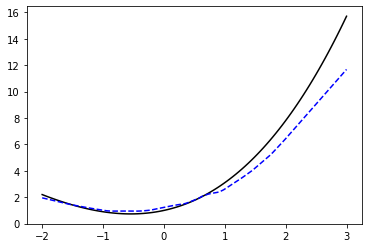

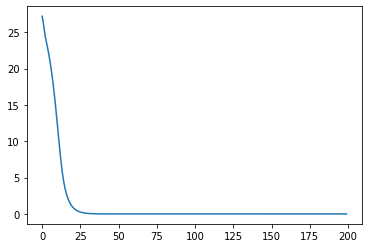

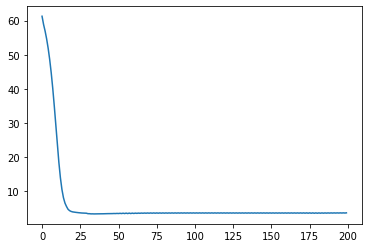

In [201]:
pred = model(xx)
plt.figure(7)
plt.plot(x, y_h, 'k-')
plt.plot(xx.detach().numpy(), pred.detach().numpy(), 'b--')
plt.figure(8)
plt.plot(loss_train)
plt.figure(9)
plt.plot(loss_test)